In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Required to import cv2 !!!
# %pip install opencv-python
import cv2

import os
import time

<h2> NMF-algoritmen </h2>
Under er en mal for hva en NMF funksjon burde ta inn og spytte ut. Merk at dere må fylle inn, akkurat nå kræsjer den.

In [2]:
def NMF(V, d, delta = 1e-9, maxiter = 1000, seed = 0):
    """
    input:
        V: (m,n) input array
        d: integer, Number of components we want to decompose V into
        delta, float, small number for safe division
        maxiter: integer, maximum number of iterations
        seed: integer, random seed
    output:
        W: (m,d) array
        H: (d,n) array
    """
    m, n = np.shape(V)

    if seed != 0:
        np.random.seed(seed)
    
    W0 = np.random.uniform(low=1e-20, high=1, size=m*d)
    H0 = np.random.uniform(low=1e-20, high=1, size=n*d)
    
    W0 *= np.sqrt(np.mean(V)/d)
    H0 *= np.sqrt(np.mean(V)/d)
    
    W0 = np.reshape(W0, (m, d))
    H0 = np.reshape(H0, (d, n))
    
    H_k = H0
    W_k = W0
    diff = np.zeros(maxiter)
    
    for k in range(maxiter):
        H_k = H_k*(np.dot(W_k.T, V))/(np.dot(np.dot(W_k.T, W_k), H_k)+ delta)
        W_k = W_k*(np.dot(V, H_k.T))/(np.dot(np.dot(W_k, H_k), H_k.T)+ delta)
        diff[k] = np.linalg.norm(V - np.dot(W_k, H_k))
    
    return W_k, H_k, diff

In [3]:
A1 = np.array([
    [1, 0],
    [0, 1]
])

A2 = np.array([
    [1, 2],
    [1, 1],
    [1, 2]
])

A3 = np.array([
    [2, 1, 1],
    [2, 1, 1],
    [1, 1, 2]
])

A4 = np.array([
    [2, 1, 0],
    [1, 2, 3],
    [0, 3, 3]
])

# 1 d)

In [4]:
W_A1, H_A1, diffff = NMF(A1, 1)
WH1 = np.dot(W_A1, H_A1)
diff = np.linalg.norm(A1 - WH1)
print(W_A1)
print(H_A1)
print(WH1)
print(f"||A1 - WH||={diff:.3e}")

W_A2, H_A2 , diffffffff= NMF(A2, 1)
WH2 = np.dot(W_A2, H_A2)
diff = np.linalg.norm(A2 - WH2)
print(W_A2)
print(H_A2)
print(WH2)
print(f"||A2 - WH||={diff:.3e}")

[[0.69678194]
 [0.31440069]]
[[1.19239928 0.53803225]]
[[0.83084229 0.37489116]
 [0.37489116 0.16915771]]
||A1 - WH||=1.000e+00
[[0.78766372]
 [0.48072479]
 [0.78766372]]
[[1.39684617 2.46709626]]
[[1.10024505 1.94324222]
 [0.67149858 1.18599434]
 [1.10024505 1.94324222]]
||A2 - WH||=4.112e-01


# 1 e)

In [5]:
W, H, diff = NMF(A1, 2)
A = np.dot(W, H)
diff = np.linalg.norm(A1 - A)
print(f"||A1 - WH||={diff:.3e}")

W, H, diff = NMF(A2, 2)
A = np.dot(W, H)
diff = np.linalg.norm(A2 - A)
print(f"||A2 - WH||={diff:.3e}")

||A1 - WH||=9.180e-10
||A2 - WH||=2.044e-09


# 1 f)

In [6]:
print(f"A3 rank: {np.linalg.matrix_rank(A3)}\nA4 rank: {np.linalg.matrix_rank(A4)}")

A3 rank: 2
A4 rank: 3


# 1 g)

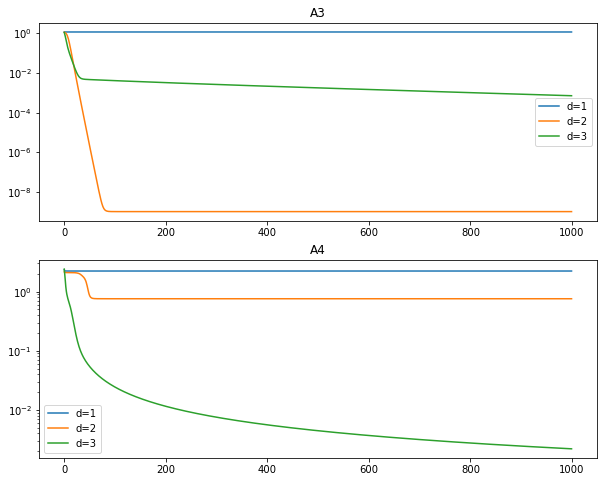

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

for d in range(1, 4):
    W, H, diff = NMF(A3, d)
    ax1.semilogy(diff, label=f"d={d}")

ax1.set_title("A3")
ax1.legend()
    
for d in range(1, 4):
    W, H, diff = NMF(A4, d)
    ax2.semilogy(diff, label=f"d={d}")
    
ax2.set_title("A4")
ax2.legend()

plt.show()

<h2> Laste inn bilder </h2>
Vi begynner med å laste inn bildene. Mange måter å gjøre dette på, men dette er en av de enkleste. <b>Denne måten krever at du har en mappe som heter "imgs" som inneholder alle bildene i samme mappe som hvor du har denne notebooken (husk å unzippe filen). Bildene blir lagret i en (24, 24, 4, N) array som heter 'faces'</b> Man kan her også bestemme antall bilder man vil bruke $N$. Flere bilder betyr lengre kjøretid men bedre resultater. N = 500 virker til å være en god middle ground.

Slik koden er nå loader man alle 10 000 bildene og forkaster alle untatt $N$ bilder. Hvilke bilder som blir trekt ut er tilfeldig valgt med `np.random.choice`. I rapporten deres trenger ikke koden for å laste inn bilder se akkurat slik ut, men vi ønsker at alle grupper bruker forskjellige bilder, derfor gjør vi en tilfeldig sampling. 

In [8]:
def load_images(N):
    """
    Loads images from cryptopunk dataset. The loading order is deterministic,
    so for a certain N the exact same images will be loaded. 
    Input:
        N, integer, number of images to load
    Output:
        faces, (24,24,4,N) numpy array containing images
    """

    # Allocate array to store images
    faces = np.zeros((24,24,4,N))

    # Iteration variable
    i = 0

    # Iterate over folders
    for subdir, dirs, files in os.walk('./imgs'):

        # Iterate over files
        for file in files:

            # Filepath to load from
            filepath = subdir + os.sep + file

            # Make sure that the file is a .png
            if filepath[-3:] == 'png':

                # Load the image
                im = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)

                # Convert it to RGBA and rescale pixels
                faces[:,:,:,i] = cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA)/255.0

                i+=1
            if i == N:
                break
                
    return faces

# Number of faces to keep in final array
N = 500

# Load all 10000 images
faces = load_images(10000)

# Select N random images
choices = np.random.choice(faces.shape[-1],N, replace = False)
faces = faces[:,:,:,choices]

# Check that the shape is correct
print(faces.shape)

(24, 24, 4, 500)


In [9]:
# Code for plotting images
def plotimgs(imgs, nplot = 8, rescale = False, filename = None):
    """
    Plots nplot*nplot images on an nplot x nplot grid. 
    Saves to given filename if filename is given
    Can also rescale the RGB channels
    input:
        imgs: (24,24,4,N) or (24,24,3,N) array containing images, where N > nplot**2
        nplot: integer, nplot**2 images will be plotted
        rescale: bool
        filename: string, figure will be saved to this location. Should end with ".png".
    """
    # We will change some of the parameters of matplotlib, so we store the initial ones
    oldparams = plt.rcParams['figure.figsize']

    # New params to make better plot. There definitely exists better ways of doing this
    plt.rcParams['figure.figsize'] = (16, 16)

    # Initialize subplots
    fig, axes = plt.subplots(nplot,nplot)

    # Set background color
    plt.gcf().set_facecolor("lightgray")

    # Iterate over images
    for idx in range(nplot**2):
        
        # Indices
        i = idx//nplot; j = idx%nplot

        # Remove axis
        axes[i,j].axis('off')

        # Rescale RGB channels by dividing my maximal value
        if rescale:
            scaled_img = np.copy(imgs[:,:,:,idx])
            scaled_img[:,:,:3] = scaled_img[:,:,:3]/np.max(scaled_img[:,:,:3])
            axes[i,j].imshow(scaled_img)
        else:
            axes[i,j].imshow(imgs[:,:,:,idx])
    
    # Tight layout so images will appear closer together
    plt.tight_layout()

    # Save if filename is given
    if filename is not None:
        plt.savefig(filename)

    plt.show()

    # Return to old parameters
    plt.rcParams['figure.figsize'] = oldparams


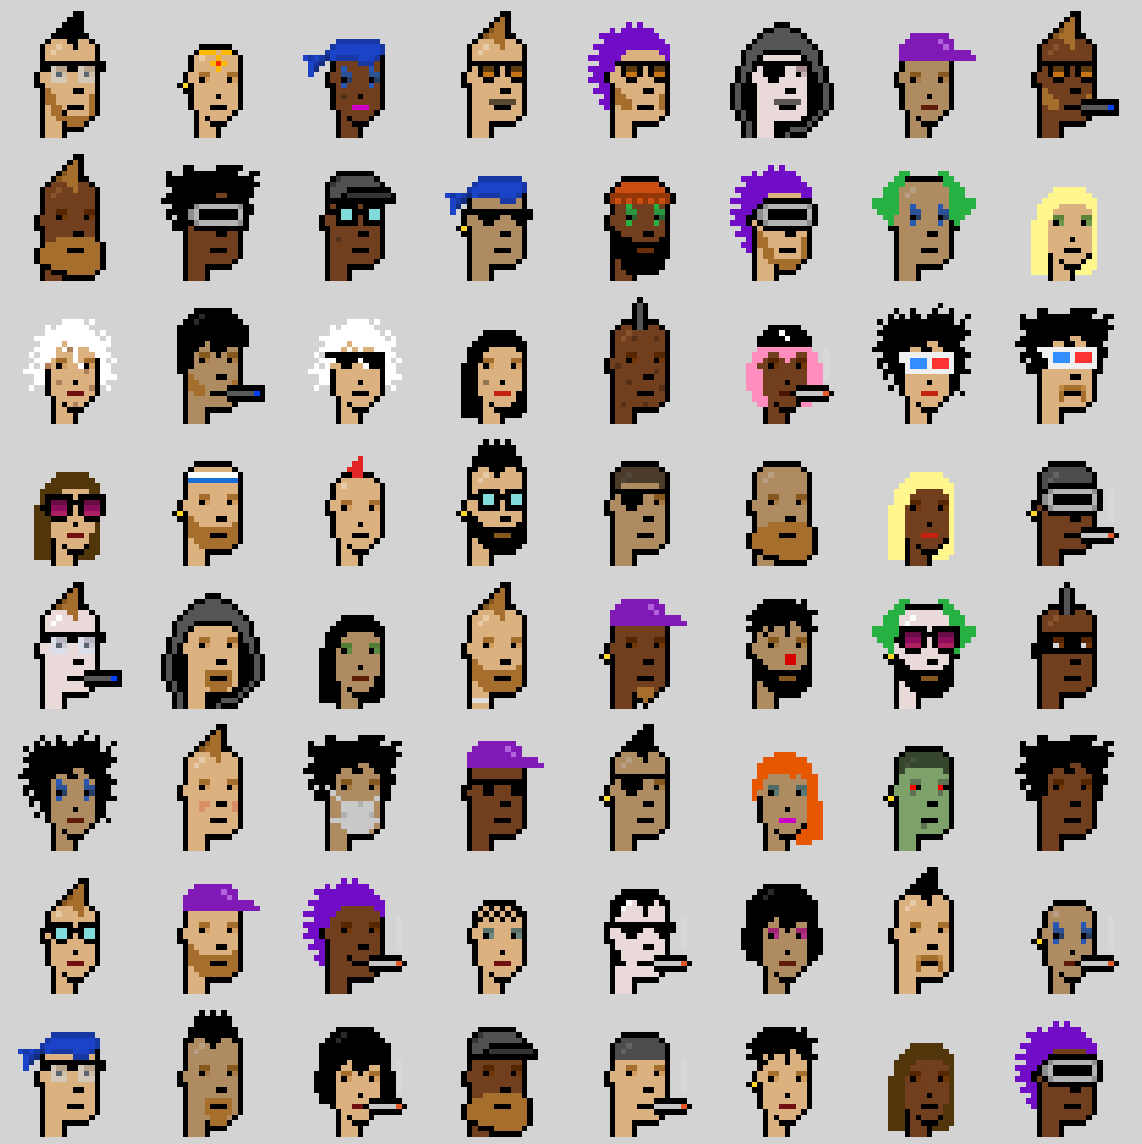

In [10]:
# Example of plotting 8 times 8 images stored in "faces" and saving the output to a file named "punks.png"
plotimgs(faces, 8, filename="punks.png")

Under er noe dere egentlig kan gjøre dere vil, men her viser vi hvordan dere kan splitte fargekanalene fra opasitetskanalen, samt reshape slik at dere har en array som dere kan anvende NMF på. 

# 2 b)

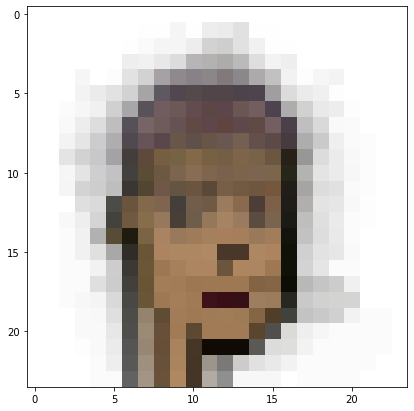

In [11]:
# Split the images into opacity and rgb channels
faces_opacity = faces[:,:,3,:]
faces_rgb = faces[:,:,:3,:]
shape = faces_rgb.shape

# Clever reshape "trick". This is the matrix we will apply the NMF to
faces_reshaped = faces_rgb.reshape(np.prod(shape)//N, N)
faces_opacity.shape

faces_mean = np.mean(faces, -1)

plt.figure(figsize = (7,7))
plt.imshow(faces_mean)
plt.show()

# 2 c)

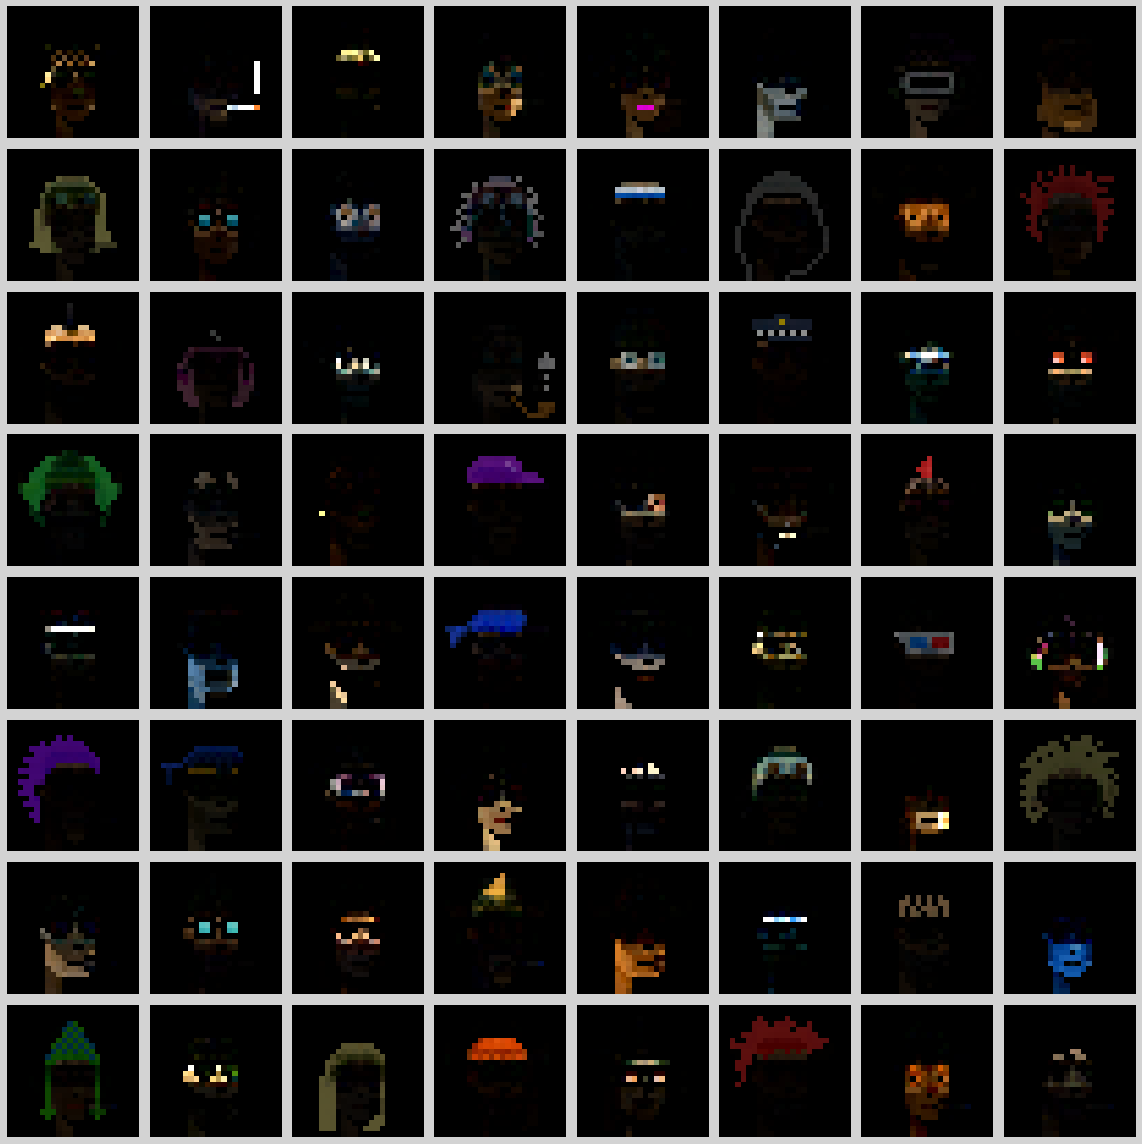

In [12]:
d = 64

W_k, H_k, diff = NMF(faces_reshaped, d)

W_k_reshape = W_k.reshape(24,24,3, d)
W_k_reshape[W_k_reshape>1] = 1 # får verdier som er større enn én, så gjør disse om til én

plotimgs(W_k_reshape, 8)

# 2 d)

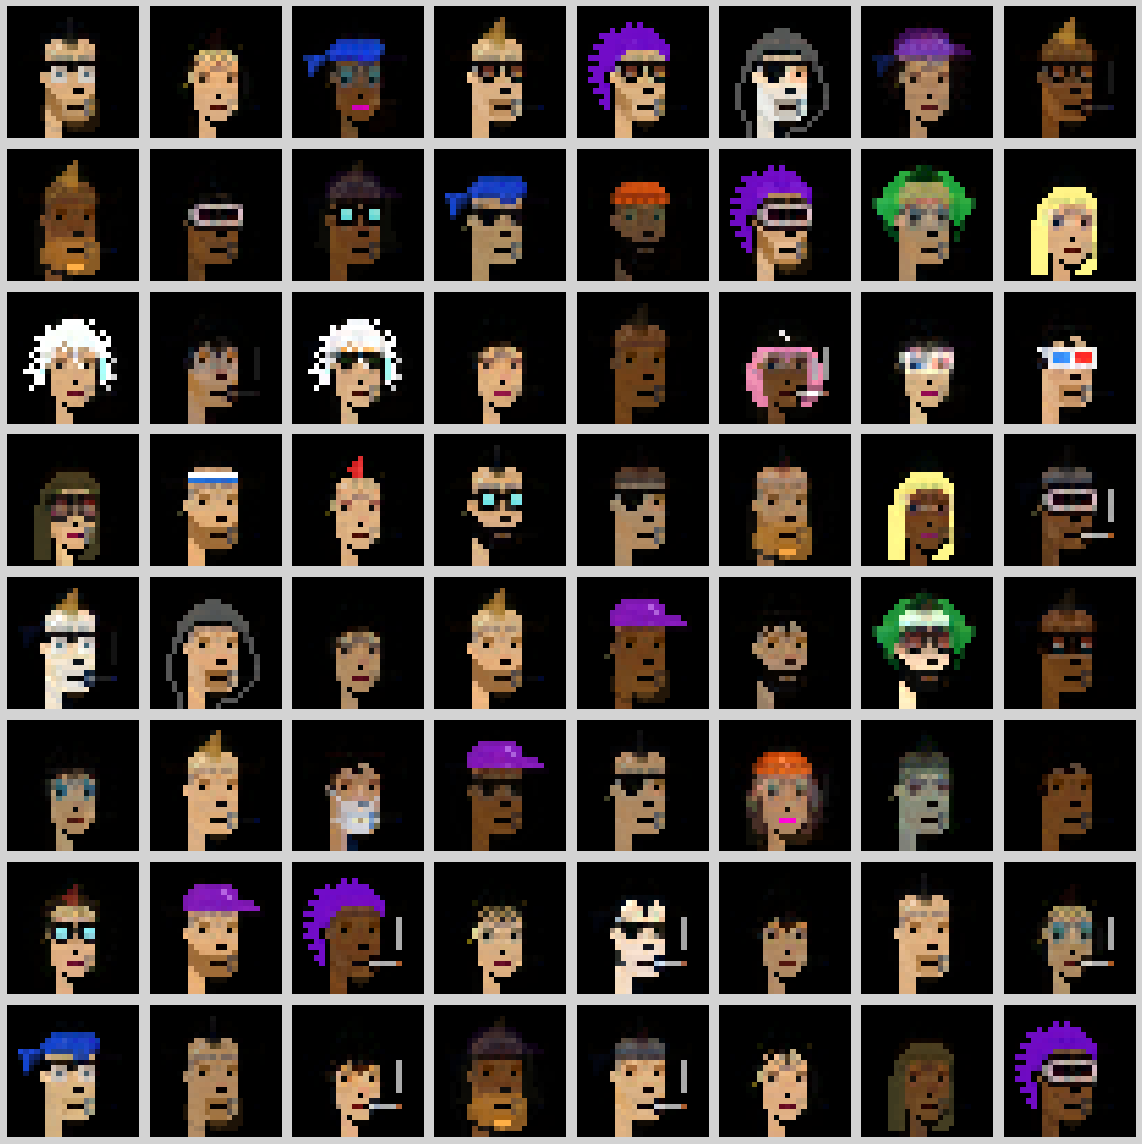

In [13]:
reconstruction = np.dot(W_k, H_k).reshape(24, 24, 3, 500)
reconstruction[reconstruction > 1] = 1

plotimgs(reconstruction, 8)

# 2 e)

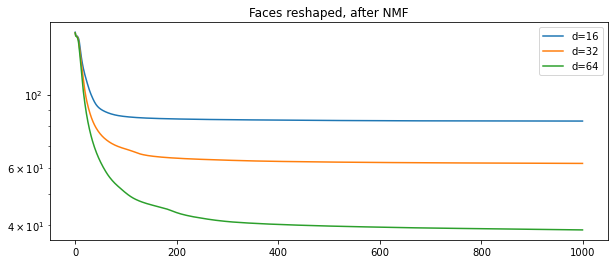

In [16]:
fig, ax = plt.subplots(figsize=(10, 4))

for d in (16, 32, 64):
    W, H, diff = NMF(faces_reshaped, d)
    ax.semilogy(diff, label=f"d={d}")

ax.set_title("Faces reshaped, after NMF")
ax.legend()

plt.show()

# 2 f)


4 og 121.52336464539721
5 og 116.21310776485801
6 og 110.31263564957378
7 og 106.23216620595494


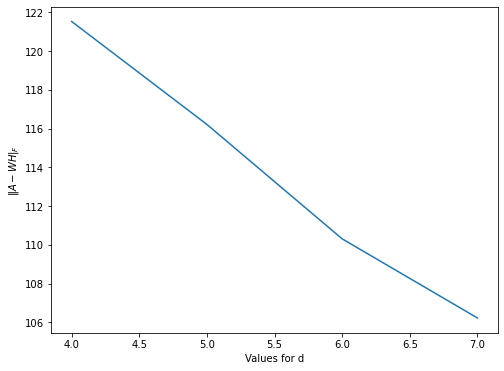

In [41]:
differences = np.zeros(4) 
d_vals = np.zeros(4)
values = [4, 5, 6, 7]
for count, d in enumerate(values):
    W, H, diff = NMF(faces_reshaped, d)
    differences[count] = diff[-1]
    d_vals[count] = d
    print(f'{d} og {diff[-1]}')
 
fig=plt.figure(figsize=(8,6))
plt.plot(d_vals, differences)
plt.xlabel('Values for d')
plt.ylabel(r'$\Vert A - WH \vert_{F}$')
plt.title('')
plt.show()


    

<h2> Legge til støy </h2>

Vi legger nå til støy i RGB kanalene slik det er forklart i oppgaveteksten

In [42]:
def add_noise(imgs_reshaped, sigma = 0.1):
    """
    Adds gaussian noise to images as described in text.
    Note that imgs must be given as a (24*24*3, N) numpy array, i.e the reshaped images
    Input:
        imgs_reshaped: (1728,N) numpy array
        sigma: scalar, noise level
    Output:
        noisy_faces: (1728,N) numpy array containing noisy images
    """

    # Array that will store the rgb channels of the noisy images
    noisy_faces = np.copy(imgs_reshaped)

    # Number of noisy values we need
    nnzero = faces_reshaped[np.nonzero(imgs_reshaped)].shape[0]

    # Sample noisy values and add noise
    noise = np.random.normal(0.0,1,nnzero)
    noisy_faces[np.nonzero(imgs_reshaped)] += sigma*noise

    # Clip to lie between 0 and 1 so that we can still interpret them as images
    noisy_faces = np.maximum(0.0,np.minimum(1.0, noisy_faces))

    return noisy_faces

Vi kan nå legge til støy til bildene våre, legge på opasitetskanalaen igjen og plotte. Dere må gjøre noe lignende etter dere har anvendt NMF og ønsker å plotte rekonstruksjoner med opasitet.

# 3 a)

42.04812226682239


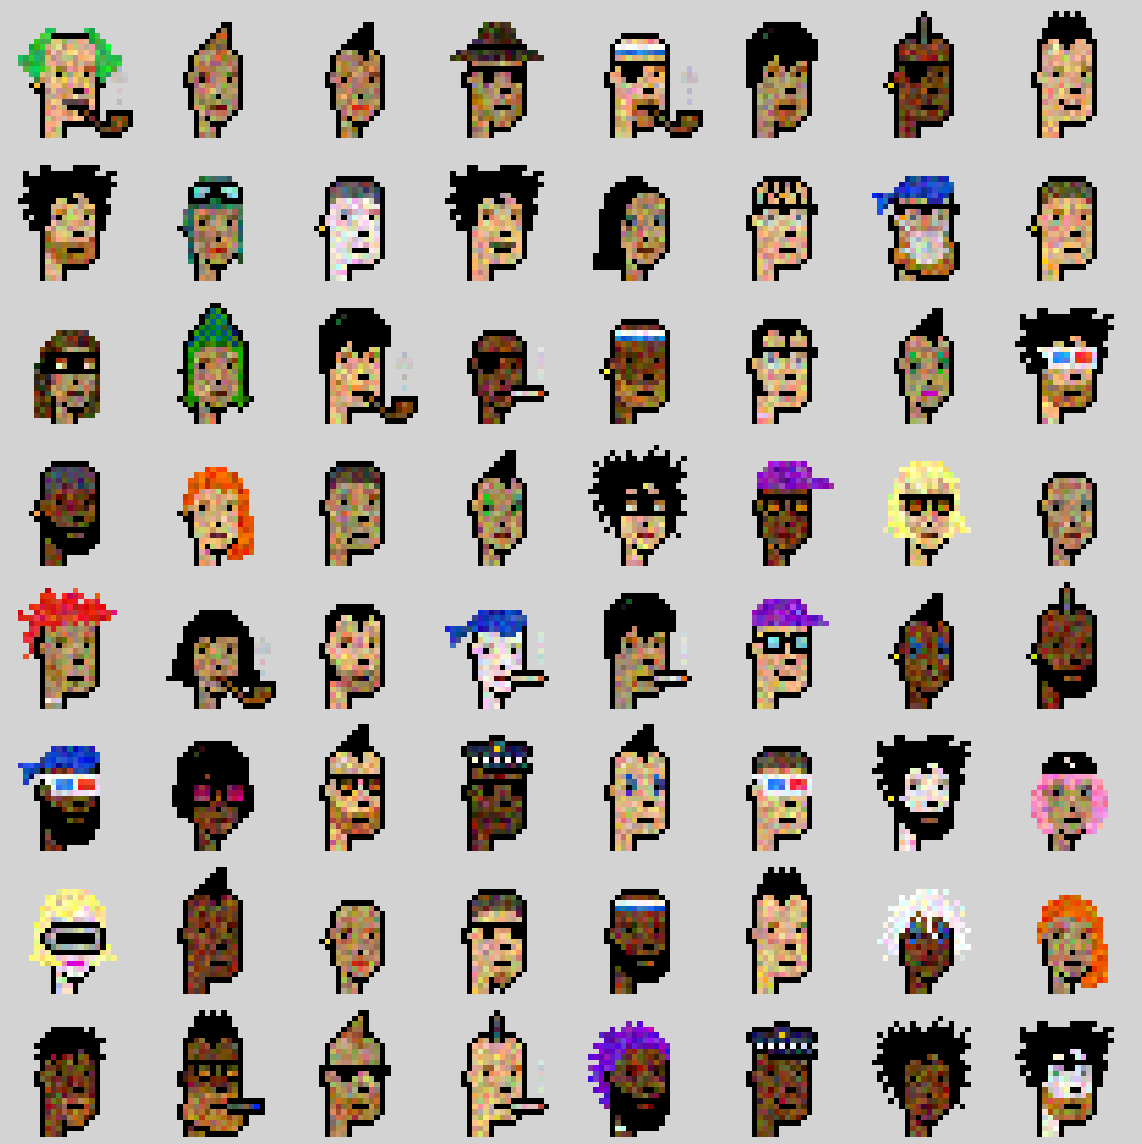

In [43]:
noisy_faces = add_noise(faces_reshaped)

# Calculate the error of the noisy images
noise_residual = np.linalg.norm(noisy_faces - faces_reshaped)
print(noise_residual)

# For plotting noisy images we add the opacity
noisy_faces_with_opacity = np.zeros(faces.shape)
noisy_faces_with_opacity[:,:,:3,:] = noisy_faces.reshape(faces_rgb.shape)
noisy_faces_with_opacity[:,:,3,:] = faces_opacity
plotimgs(noisy_faces_with_opacity)

# 3 b)

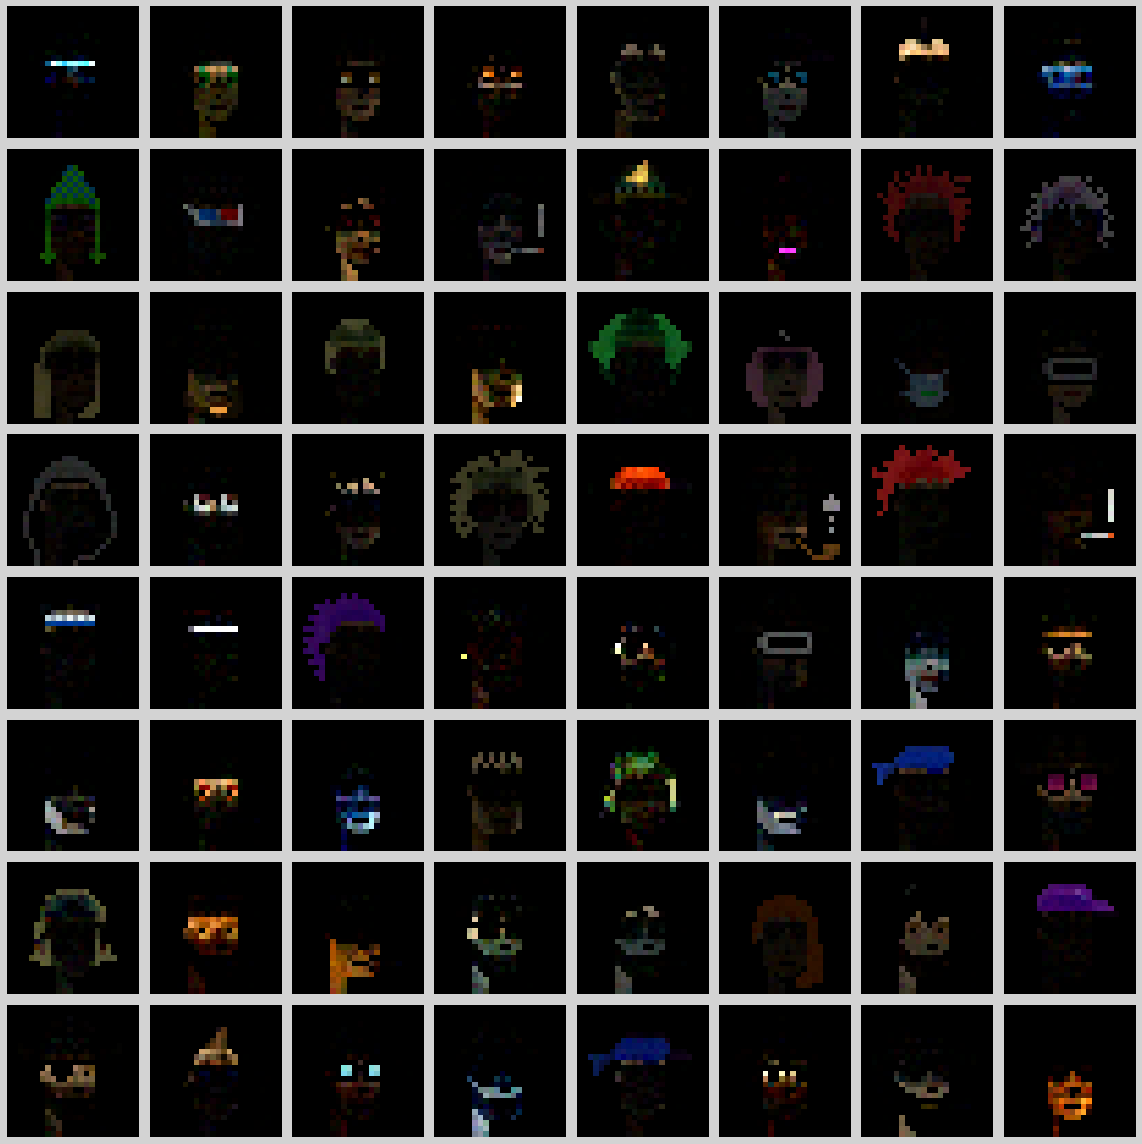

In [45]:
d = 64

W_k_Noisy, H_k_Noisy, diff = NMF(noisy_faces, d)

W_k_reshape = W_k_Noisy.reshape(24,24,3, d)
W_k_reshape[W_k_reshape>1] = 1 # får verdier som er større enn én, så gjør disse om til én

plotimgs(W_k_reshape, 8)

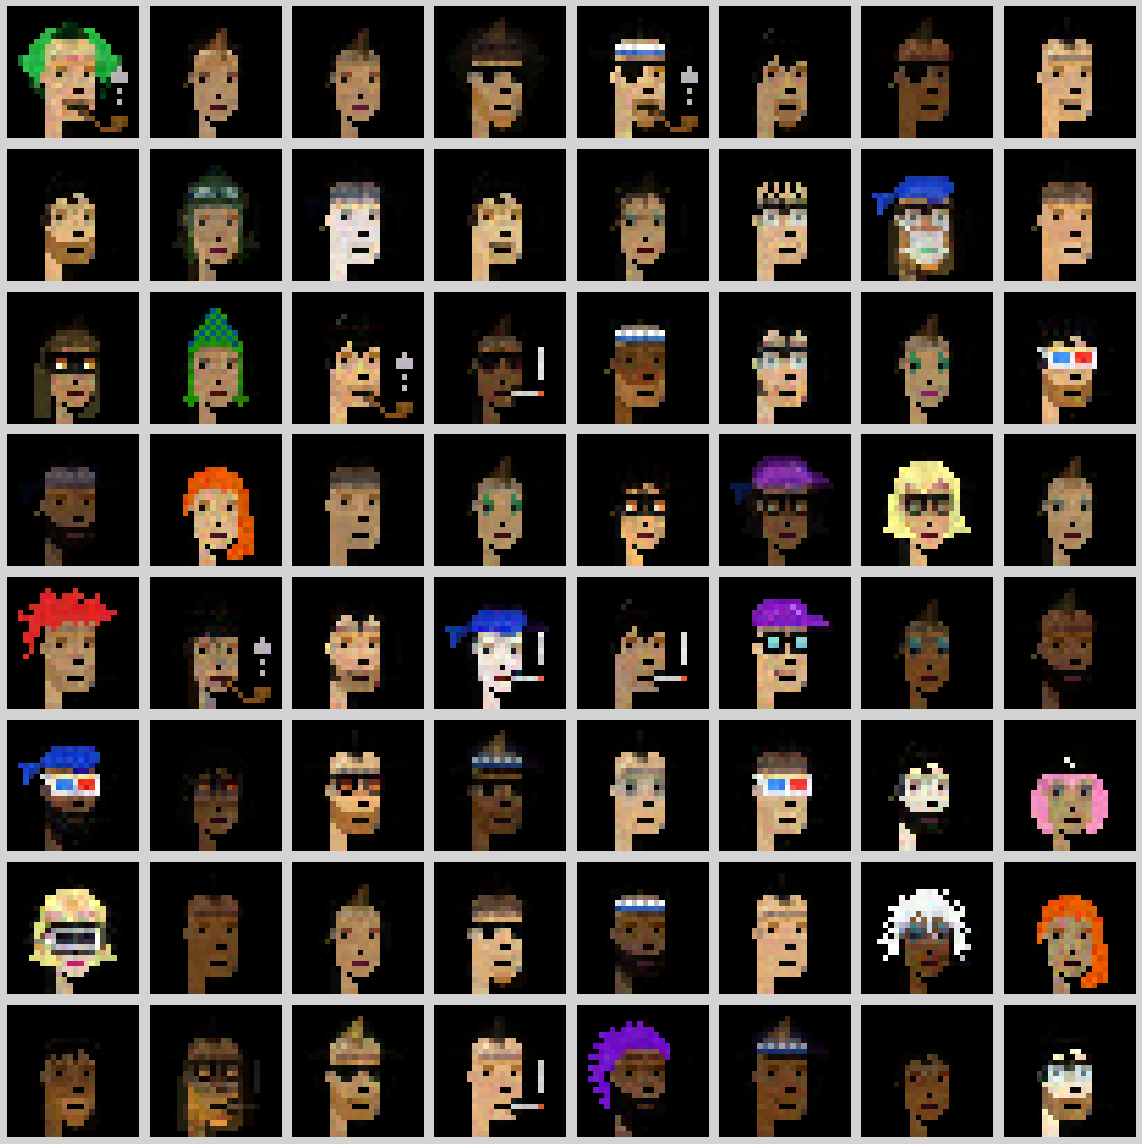

In [46]:
reconstruction = np.dot(W_k_Noisy, H_k_Noisy).reshape(24, 24, 3, 500)
reconstruction[reconstruction > 1] = 1

plotimgs(reconstruction, 8)

# 3 c)

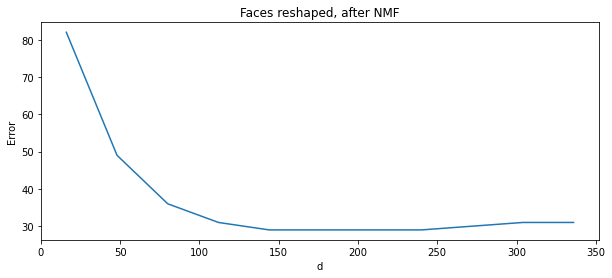

In [50]:
fig, ax = plt.subplots(figsize=(10, 4))

d_values = np.arange(16, 320+32, 32)
error = np.zeros_like(d_values)

for i, d in enumerate(d_values):
    W, H, diff = NMF(noisy_faces, d)
    error[i] = np.linalg.norm(faces_reshaped - W @ H)
    
ax.plot(d_values, error)
ax.set_title("Faces reshaped, after NMF")
ax.set_xlabel("d")
ax.set_ylabel("Error")

plt.show()

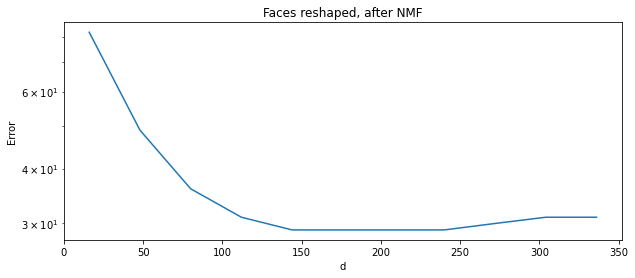

In [51]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.semilogy(d_values, error)
ax.set_title("Faces reshaped, after NMF")
ax.set_xlabel("d")
ax.set_ylabel("Error")

plt.show()